In [91]:
import tensorflow as tf
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [92]:
education_df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis Evaluation DataSet/Education.csv')
finance_df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis Evaluation DataSet/Finance.csv')
politics_df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis Evaluation DataSet/Politics.csv')
sports_df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis Evaluation DataSet/Sports.csv')

In [93]:
df = pd.concat([education_df, finance_df,politics_df,sports_df], ignore_index=True)

In [94]:
df

,Text,Label
0,The impact of educational reforms remains unce...,positive
1,Critics argue that recent improvements in the ...,negative
2,Innovative teaching methods have led to unexpe...,positive
3,"Despite budget constraints, the school has man...",positive
4,The true effectiveness of online learning plat...,negative
...,...,...
204,Sports fandom can foster a sense of community ...,positive
205,Sports events offer a platform for showcasing ...,positive
206,The pressure to win in sports can overshadow t...,negative
207,Sports programs in schools play a crucial role...,positive


<ipython-input-95-a384046ecc76>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


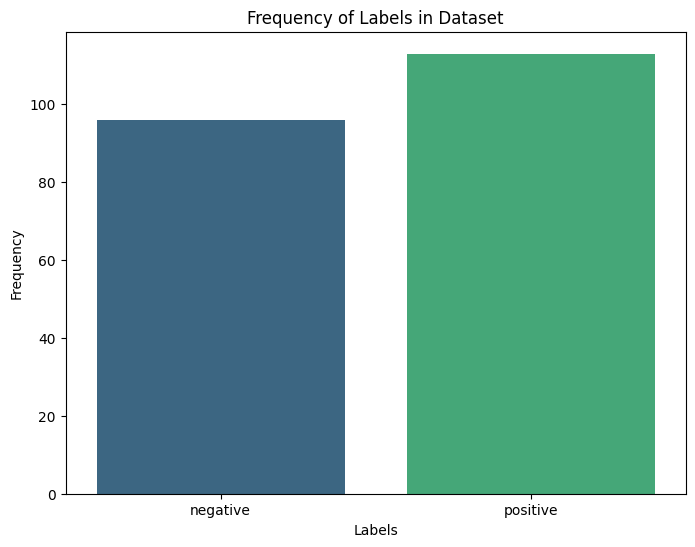

In [95]:
label_counts = df['Label'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Labels in Dataset')
plt.show()

In [96]:
df['Label'].isnull().sum()

0

In [97]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [98]:
df['Text'] = df['Text'].astype(str)

In [99]:
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)
df['Text'] = df['Text'].apply(clean)

In [100]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem
df['Text'] = df['Text'].apply(is_special)

In [101]:
def to_lower(text):
    return text.lower()
df['Text'] = df['Text'].apply(to_lower)

In [102]:
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

df['Text'] = df['Text'].apply(rem_stopwords)

In [103]:
def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

df['Text'] = df['Text'].apply(stem_txt)

In [104]:
df.head()

,Text,Label
0,impact educ reform remain uncertain despit ext...,positive
1,critic argu recent improv school system mere s...,negative
2,innov teach method led unexpect challeng stude...,positive
3,despit budget constraint school manag maintain...,positive
4,true effect onlin learn platform still matter ...,negative


In [105]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)

In [106]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [107]:
from keras.preprocessing.text import Tokenizer
max_words = 10000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)

In [108]:
import pickle

tokenizer_filename = 'SN_tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [109]:
embedding_dim = 100
batch_size = 64
epochs = 10

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(SimpleRNN(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [110]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1020201 (3.89 MB)
Trainable params: 1020201 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [112]:
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
3/3 [==============================] - 2s 210ms/step - loss: 0.6877 - accuracy: 0.5800 - val_loss: 0.6991 - val_accuracy: 0.4706
Epoch 2/10
3/3 [==============================] - 0s 121ms/step - loss: 0.6557 - accuracy: 0.6267 - val_loss: 0.6771 - val_accuracy: 0.6471
Epoch 3/10
3/3 [==============================] - 0s 117ms/step - loss: 0.6004 - accuracy: 0.8000 - val_loss: 0.6693 - val_accuracy: 0.5882
Epoch 4/10
3/3 [==============================] - 0s 117ms/step - loss: 0.5580 - accuracy: 0.8533 - val_loss: 0.6509 - val_accuracy: 0.7647
Epoch 5/10
3/3 [==============================] - 0s 111ms/step - loss: 0.5010 - accuracy: 0.9067 - val_loss: 0.6392 - val_accuracy: 0.5294
Epoch 6/10
3/3 [==============================] - 0s 109ms/step - loss: 0.4505 - accuracy: 0.9667 - val_loss: 0.6135 - val_accuracy: 0.8824
Epoch 7/10
3/3 [==============================] - 0s 119ms/step - loss: 0.3830 - accuracy: 0.9800 - val_loss: 0.5930 - val_accuracy: 0.8235
Epoch 8/10
3/3 [====

In [113]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)

2/2 [==============================] - 0s 12ms/step - loss: 0.5792 - accuracy: 0.7381


In [114]:
test_loss

0.5791583061218262

In [115]:
test_accuracy

0.738095223903656

In [116]:
y_test_pred = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

2/2 [==============================] - 0s 10ms/step


In [117]:
model.save('Sentimental_Analysis_Evakuation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


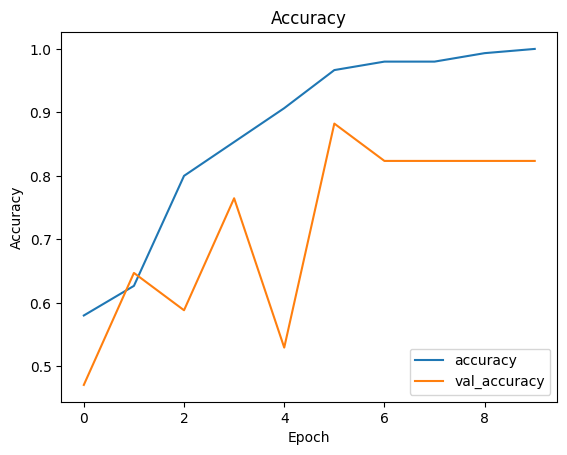

In [118]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.show()

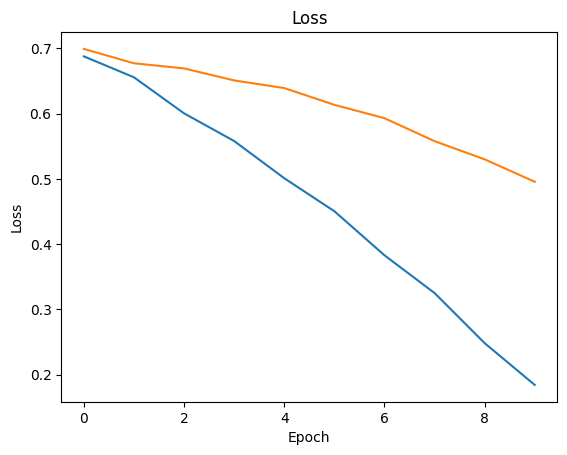

In [119]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [120]:

def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned, '', text)


def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem


def to_lower(text):
    return text.lower()


def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]


def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])


def clean_text(text):
    text = clean(text)
    text = is_special(text)
    text = to_lower(text)
    text = rem_stopwords(text)
    text = stem_txt(text)
    return text

In [129]:
user_input = "Financial bubbles can form when asset prices become disconnected from their intrinsic value."
user_input=clean_text(user_input)
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

user_predictions = model.predict(user_padded)
print(user_predictions)

1/1 [==============================] - 0s 72ms/step
[[0.08879949]]
